In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
dataset, info = tfds.load("mnist", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incomplete5X377B',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",

In [ ]:
class_names = info.features['label'].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
n_classes = info.features['label'].num_classes
n_classes

10

In [ ]:
train_set_size = info.splits['train'].num_examples
test_set_size = info.splits['test'].num_examples

train_set_size, test_set_size

(60000, 10000)

# Training, Validation, Test Set 분리

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load('mnist', as_supervised=True, split=['test[0%:]', 'train[:16.666%]', 'train[16.666%:]'])

In [ ]:
len(train_set_raw), len(valid_set_raw), len(valid_set_raw)

(50000, 10000, 10000)

# 데이터 전처리
  

In [ ]:
import keras

In [ ]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  image = tf.image.grayscale_to_rgb(resized_image)
  final_image = keras.applications.vgg16.preprocess_input(image)
  return final_image, label


batch_size = 50

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

# 데이터 증식을 사용한 특성 추출


## VGG16 합성곱 기반 층을 만들고 마지막에서 네 번째 층까지 모든 층 동결하기




In [ ]:
from keras import layers

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
len(conv_base.trainable_weights)  # 합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수

6

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 데이터 증식 단계와 밀집 분류기를 합성곱 기반 층에 추가하기

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # 데이터 증식 적용
x = keras.applications.vgg16.preprocess_input(x)  # 입력 값의 스케일 조정
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(50)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)


## 모델 미세 조정하기

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

checkpoint = [
    keras.callbacks.ModelCheckpoint(
        filepath='mnist_augmentation',
        save_best_only=True,
        monitor='val_loss'
    )
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_set,
    epochs=5,
    steps_per_epoch = len(train_set_raw) / batch_size,
    validation_data=valid_set,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/5
1000/1000 [==============================] - 324s 309ms/step - loss: 0.8466 - accuracy: 0.8246 - val_loss: 0.1894 - val_accuracy: 0.9448
Epoch 2/5
1000/1000 [==============================] - 306s 306ms/step - loss: 0.1919 - accuracy: 0.9444 - val_loss: 0.1274 - val_accuracy: 0.9630
Epoch 3/5
1000/1000 [==============================] - 306s 306ms/step - loss: 0.1291 - accuracy: 0.9625 - val_loss: 0.0995 - val_accuracy: 0.9718
Epoch 4/5
1000/1000 [==============================] - 345s 345ms/step - loss: 0.1013 - accuracy: 0.9697 - val_loss: 0.0896 - val_accuracy: 0.9737
Epoch 5/5
1000/1000 [==============================] - 345s 345ms/step - loss: 0.0818 - accuracy: 0.9755 - val_loss: 0.0668 - val_accuracy: 0.9800


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0     

## 결과 그래프로 나타내기

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

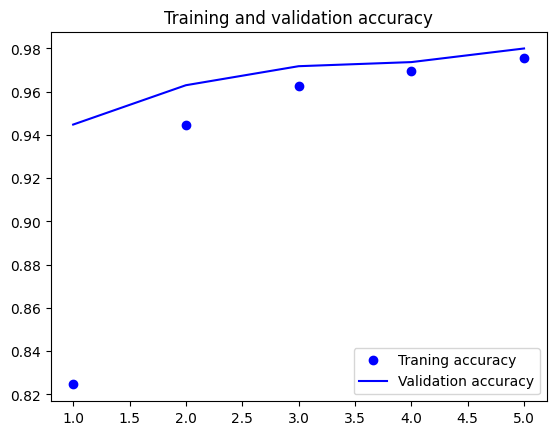

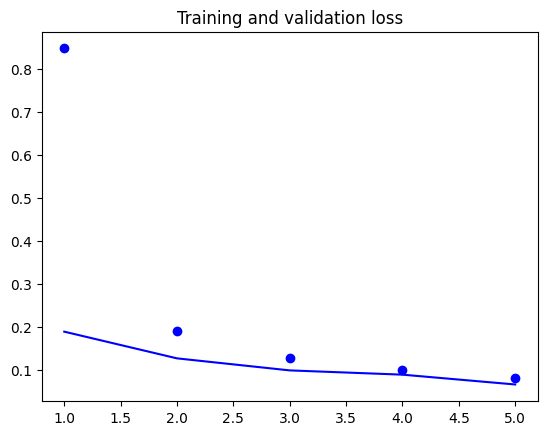

In [ ]:
plt.plot(epochs, acc, 'bo', label='Traning accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.show()

## 테스트 세트에서 모델 평가하기

In [ ]:
import time

test_model = keras.models.load_model(
    'mnist_augmentation'
)

start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_set)
end_time = time.time()
prediction_time = end_time - start_time
print(f'prediction time: {prediction_time}')

200/200 [==============================] - 46s 226ms/step - loss: 0.0595 - accuracy: 0.9830
prediction time: 45.63990092277527
